In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = self.nrow - 1

    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol-1, max(0, self.x+change[action][0]))
        self.y = min(self.nrow-1, max(0, self.y+change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False

        if self.y == self.nrow - 1 and self.x > 0:
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class Sarsa:
    def __init__(self, ncol, nrow, eps, alpha, gamma, n_action=4):
        self.Q_table = np.zeros((ncol*nrow, n_action))
        self.n_action = n_action
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma

    def take_action(self, state):
        if np.random.random() < self.eps:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

In [3]:
class NstepSarsa(Sarsa):
    def __init__(self, n, ncol, nrow, eps, alpha, gamma, n_action=4):
        super().__init__(ncol, nrow, eps, alpha, gamma, n_action)
        self.n = n
        self.state_list = []
        self.action_list = []
        self.reward_list = []

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)

        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []


In [4]:
class QLearning(Sarsa):
    def __init__(self, ncol, nrow, eps, alpha, gamma, n_action=4):
        super().__init__(ncol, nrow, eps, alpha, gamma, n_action)
    
    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1479.64it/s, episode=500.0, return=-19.100]


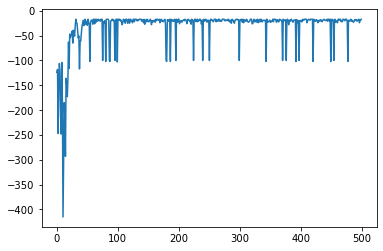

In [5]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
eps = 0.1
alpha = 0.1
gamma = 0.9
agent = NstepSarsa(5, ncol, nrow, eps, alpha, gamma)
n_episode = 500

return_list = []
for i in range(10):
    with tqdm(total=int(n_episode/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(n_episode/10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': f'{n_episode/10*i+i_episode+1}', 
                    'return': f'{np.mean(return_list[-10:]):.3f}'})
            pbar.update()

episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.show()

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1020.21it/s, episode=500.0, return=-19.100]


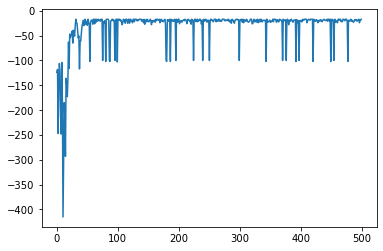

In [6]:
import rl_utils

ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
eps = 0.1
alpha = 0.1
gamma = 0.9
agent = NstepSarsa(5, ncol, nrow, eps, alpha, gamma)
n_episode = 500

return_list = []
@rl_utils.run_episodes(n_episode, return_list)
def run_sarsa():
    episode_return = 0
    state = env.reset()
    action = agent.take_action(state)
    done = False
    while not done:
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        episode_return += reward
        agent.update(state, action, reward, next_state, next_action, done)
        state = next_state
        action = next_action
    return episode_return

run_sarsa()
episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.show()


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1923.11it/s, episode=500.0, return=-61.700]


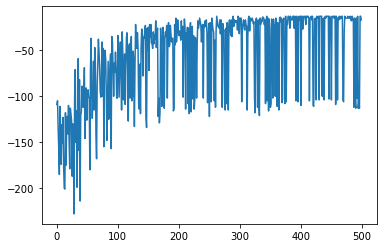

In [35]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
eps = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, eps, alpha, gamma)
n_episode = 500

return_list = []
for i in range(10):
    with tqdm(total=int(n_episode/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(n_episode/10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix({'episode': f'{n_episode/10*i+i_episode+1}', 
                    'return': f'{np.mean(return_list[-10:]):.3f}'})
            pbar.update()

episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.show()

In [12]:
def print_agent(agent, env, action_symbol, disasters=[], ends=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            state = i * env.ncol + j
            if state in disasters:
                print('****', end=' ')
            elif state in ends:
                print('EEEE', end=' ')
            else:
                state = i * env.ncol + j
                a = agent.best_action(state)
                pi_str = ''
                for k in range(len(action_symbol)):
                    if a[k] > 0:
                        pi_str += action_symbol[k]
                    else:
                        pi_str += 'o'
                print(pi_str, end=' ')
        print()

In [36]:
print_agent(agent, env, ['^', 'v', '<', '>'], disasters=list(range(37, 47)), ends=[47])

^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 
